In [0]:
"""
Author: Srikaran Elakurthy 

Description:


 The current algorithm trains a neural network to predcit the genre of a song given the lyric. A novel architecture for the deep leanring model is proposed. 
Pre-processing the data and converting it to sequences from text is necessary for a seq2seq paradigm. A word-index dictionary is constructed such that for each unique
word in a vocabulary, a number is assigned depending on the frequency of its occurrence. The smaller the number, the higher the frequency of occurrence. The text to 
sequences function from the Keras library is used to convert each lyric in the train set into an array of numbers that represent the sequence of words in that lyric.
GloVe Word embeddings are used for the deep learning model.

Because of its extensive use in many classification tasks, it was selected to be applied for this task. The longest lyric in the data set consists of 3432 words/tokens.
After converting the lyrics to sequences, padding is performed for all the lyrics to match the length of the largest lyric which is 3432. 
The first layer is the input layer which consists of 3432 neurons. The embedding layer then replaces each word/token with 300-dimensional
vectors extracted from the GloVe dictionary. A series of convolution operations followed by max-pooling operations are performed through different layers.

The genres form the Y values for the dataset. They are encoded in one hot format and used for both training and testing. 

The number of neurons in the first, second, third, fourth, and fifth layers is 500, 400, 300, 200, and 100 respectively. 
MaxPooling1D(5) was performed after every convolutional layer. SpatialDropout1D(0.2) was introduced in the architecture to prevent overfitting. 
‘ReLU’ was used as the activation function in the convolutional layers. ‘Adam’ is selected as the optimizer and ‘categorical cross-entropy’ was used as the loss function. 
The last layer is the dense layer which consists of 11 neurons as there as 11 genres and they use softmax as their activation function.
The model was trained for 30 epochs over the train set and its performance was tested over the test set. 

The classification report is generated to evaluate the model's performance. 



Command to run the file: 

Open the ipynb notebook in Jupyter Lab and go to the menu bar on the top, click on 'Run' and from the dropdown select the 'Run All' option to run
all the cells in the notebook. 

Inputs and Outputs:  The input to the program is 'oversampling_train.csv' which is associated with the sampling distribution where the samples associated with the Rock genre
are undersmapled and all the records associated with the other genres are oversampled. The test set is also provided as the input file. The output of the program are the predictions
for each lyric in the test set. The classification report and the model plots are also generated as the outputs.


Example:

INPUT: oversampling_train.csv and oversampling_test.csv
OUTPUT: Classificaton report in the string form as shown below and the plot of the model generated as PNG. It can also be found in the end of this program.

 precision    recall  f1-score   support\n\n 
         R&B          0.80      0.79      0.80      5753\n
        Country       0.93      0.94      0.93      5725\n
        Jazz          0.95      1.00      0.98      5694\n
        Hip-Hop       0.86      0.83      0.84      5708\n 
        Rock          0.96      1.00      0.98      5448\n 
        Folk          0.75      0.86      0.80      4340\n
        Other         0.73      0.78      0.75      5650\n
        Metal         0.91      0.91      0.91      5433\n 
        Indie         0.50      0.46      0.48      7014\n
        Pop           0.95      0.97      0.96      5381\n
        Electronic    0.56      0.51      0.53     10111\n\n

 accuracy                                 0.79     66257\n   
 macro avg            0.81      0.82      0.81     66257\n
 weighted avg         0.79      0.79      0.79     66257\n'


*The inputs to the program must be in the same folder as the script.

"""



"""
The relevant modules are imported below.
"""

import numpy as np
import pandas as pd
import re

from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
#import emoji
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn.externals import joblib 
from sklearn.preprocessing import Normalizer
from scipy.sparse import hstack
from sklearn.metrics import classification_report
from statistics import mean
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras.layers import Embedding
from keras.layers.core import SpatialDropout1D
from keras.layers.core import Dropout
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.layers import Dense, Activation, Flatten
from keras.layers import MaxPooling1D
import keras
from keras import backend as K
import tensorflow as tf
pip install emoji

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
Using TensorFlow backend.


In [0]:
"""
This function is used to load the embeddings from the input Glove Model file. It generates a dictionary of words and their embeddings in the GloVe model.
"""
def loadembng(filename):
# load embedding into memory, skip first line
    f = open(filename,'r')
    lines = f.readlines()
    f.close()

    embng = dict()
    for line in lines:
        parts = line.split()
        # key is string word, value is numpy array for vector
        embng[parts[0]] = np.asarray(parts[1:], dtype='float32')
    return embng

In [0]:
'''
This function is used to build the embedding matrix for the vocabulary of the dataset. It takes the embedding dictionary and the 
vocabulary as input. It maps each word in the vocabulary to the respective embedding vector of the word from the GloVe model. The whole weight matrix is returned.
'''
def get_weight_matrix(embedding, vocab):

    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, 300))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        vector = embedding.get(word)
        if vector is not None:
            weight_matrix[i] = vector
    return weight_matrix

In [0]:
#reading the relevant sampled distribution in the CSV format.
df=pd.read_csv("/content/drive/My Drive/OverSampling/oversampling_train.csv")

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df.head()

,Unnamed: 0,lyrics,genre
0,253258,a kay a kay jordan de shoe pairan vich kaali h...,Other
1,99993,i remeb when i saw you at the diner s yet my h...,Rock
2,267744,you left the water run when you left me here b...,Country
3,132459,thing that happen when you fall asleep when yo...,Electronic
4,312277,oh my god my heart s as heavi as a stone and w...,Indie


In [0]:
#dropping columns with 'unnamed' string in them which are not needed for training
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)



In [0]:
df.shape

(265026, 2)

In [0]:
df['genre'].unique()

array(['Other', 'Rock', 'Country', 'Electronic', 'Indie', 'Metal',
       'Hip-Hop', 'Pop', 'Folk', 'R&B', 'Jazz'], dtype=object)

In [0]:
df['lyrics'].groupby(df['genre']).describe()

,count,unique,top,freq
genre,,,,
Country,11390,10972,deep within my heart lie a melodi a song of ol...,7
Electronic,5605,5250,babi i don t know just whi i love you so mayb ...,8
Folk,1426,1387,black dust in orbit cascad down like a parachu...,5
Hip-Hop,18417,17000,good god almighti like back in the old day you...,7
Indie,2388,2329,how much would you bet that if i tri hard enou...,3
Jazz,5904,5189,gee but it s tough to be broke kid it s not a ...,9
Metal,17243,16878,bonu track,16
Other,3224,2986,embrac me my sweet embrac you ! embrac me you ...,8
Pop,27834,26022,hey hey you you i don t like your girlfriend n...,9


In [0]:
#Extracting the X and Y values
X=df['lyrics'].values
Y=df['genre']

In [0]:
#generating the train and test sets from the X and Y extractions in the ratio of 80:20.
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(141216,) (141216,)
(35304,) (35304,)


In [0]:
Y_train.unique()

array(['Other', 'Rock', 'Country', 'Electronic', 'Indie', 'Metal',
       'Hip-Hop', 'Pop', 'Folk', 'R&B', 'Jazz'], dtype=object)

In [0]:
#one hot encoding the genre column in the train set, which are the Y_train values.
Ytrain = pd.get_dummies(Y_train).values
Ytrain

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [0]:
#one hot encoding the genres of the test set.
Ytest = pd.get_dummies(Y_test).values
Ytest

array([[0, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)

In [0]:
#defining the tokenizer
tknzr1 = Tokenizer()
tknzr1.fit_on_texts(X_train)

In [0]:
#converting the words in the lyrics to test sequences using the Keras texts_to_sequences function.
encod_lyr = tknzr1.texts_to_sequences(X_train)

In [0]:
#Padding the text to sequences with 0 to match the maximum length of words in the lyric of the dataset.
Xtrain = pad_sequences(encod_lyr, maxlen=3432, padding='post')

In [0]:
#Increasing the length of the vocabulary by 1 to reflect the padding.
vocab_size = len(tknzr1.word_index) + 1

In [0]:
#Load the GloVe model from the txt file.
raw_embedding = loadembng('/content/drive/My Drive/NeuralNetwork/glove.6B.300d.txt')

In [0]:
#preparing the weight matrix and the embedding layer
embedding_vectors = get_weight_matrix(raw_embedding, tknzr1.word_index)
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_vectors], input_length=3432, trainable=False)

In [0]:
#building the Neural Network Model using CNNs. Detailed description is provided at the beginning of the program. Becuase one-hot encoding was considered, we use
#categorical cross entropy.

model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(500, 3, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(400, 3, activation='relu'))
model.add(MaxPooling1D(5))
model.add(SpatialDropout1D(0.2))
model.add(Conv1D(300, 3, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(200, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(100, 3, activation='relu'))
model.add(SpatialDropout1D(0.2))

model.add(Flatten())
model.add(Dense(11, activation='softmax'))
model.compile(loss=['categorical_crossentropy'], optimizer='adam', metrics=['accuracy'])

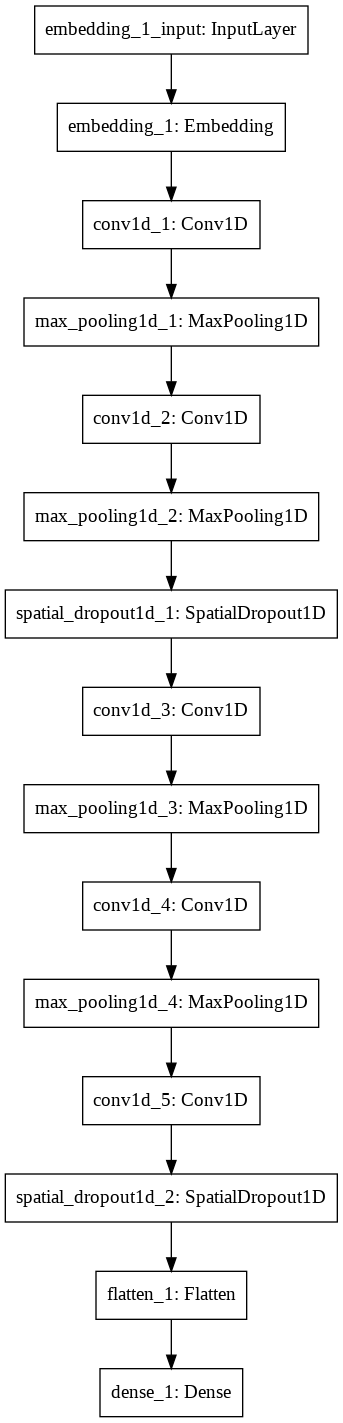

In [0]:
#the constructed model is plotted and stored in model.png
from keras.utils import plot_model
plot_model(model, to_file='/content/drive/My Drive/NeuralNetwork/oversampled/model.png')

In [0]:

#The model defined above is trained on the Xtrain and Ytrain sets. The batch size and epochs are configured below.
epochs = 30
batch_size = 128

history = model.fit(Xtrain, Ytrain, epochs=epochs, batch_size=batch_size,validation_split=0.1)




Train on 238523 samples, validate on 26503 samples
Epoch 1/30
238523/238523 [==============================] - 256s 1ms/step - loss: 1.8410 - accuracy: 0.3594 - val_loss: 1.5253 - val_accuracy: 0.4642
Epoch 2/30
238523/238523 [==============================] - 255s 1ms/step - loss: 1.3144 - accuracy: 0.5419 - val_loss: 1.1193 - val_accuracy: 0.6079
Epoch 3/30
238523/238523 [==============================] - 255s 1ms/step - loss: 1.0283 - accuracy: 0.6386 - val_loss: 0.9228 - val_accuracy: 0.6751
Epoch 4/30
238523/238523 [==============================] - 257s 1ms/step - loss: 0.8676 - accuracy: 0.6932 - val_loss: 0.8400 - val_accuracy: 0.7037
Epoch 5/30
238523/238523 [==============================] - 256s 1ms/step - loss: 0.7751 - accuracy: 0.7257 - val_loss: 0.7943 - val_accuracy: 0.7184
Epoch 6/30
238523/238523 [==============================] - 256s 1ms/step - loss: 0.7074 - accuracy: 0.7469 - val_loss: 0.7617 - val_accuracy: 0.7360
Epoch 7/30
238523/238523 [=======================

In [0]:
#The model is saved with a name given as input to the model.save function.
model.save("model_ovrsamp79.h5")

In [0]:
#The trained model is loaded from the h5 file 

from keras.models import model_from_json, load_model
modelprev=load_model('model_ovrsamp79.h5')

In [0]:
#The test set is read from the given input file.
tst=pd.read_csv('oversampling_test.csv')

In [0]:
#A little pre-processing to drop column containing the string unnamed from the dataset.
tst.drop(tst.columns[tst.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)



In [0]:
#defining the X_test and Y_test from the test set.
X_test=tst['lyrics']
Y_test=tst['genre']

In [0]:
Y_test

0               R&B
1           Country
2              Jazz
3           Hip-Hop
4           Country
            ...    
66252    Electronic
66253         Indie
66254          Jazz
66255          Rock
66256         Other
Name: genre, Length: 66257, dtype: object

In [0]:
#One hot encoding the values of the genres in the test set to match the train set dummies.
Ytest = pd.get_dummies(Y_test).values
Ytest

array([[0, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [0]:
#Performing text to sequences for the test set using the tokenizer applied on the test set.
encod_lyr_tst = tknzr1.texts_to_sequences(X_test)

In [0]:
#Padding the sequences to match the train set's maximum lengths of lyric.
Xtest = pad_sequences(encod_lyr_tst, maxlen=3432, padding='post')

In [0]:
#predicting the genres for the test instances.
ypred=model.predict(Xtest)

In [0]:
#looking at the probabilities given to the predictions for the first instance.
ypred[0]

array([4.1408592e-04, 1.6886320e-07, 5.5451666e-14, 9.9087101e-06,
       6.7748671e-13, 3.1461616e-03, 2.5342272e-08, 4.6115454e-09,
       3.0239134e-03, 9.9202806e-01, 1.3777483e-03], dtype=float32)

In [0]:

pred = list()
for i in range(len(ypred)):
    pred.append(np.argmax(ypred[i]))

#Converting one hot encoded test label to label
test = list()
for i in range(len(Ytest)):
    test.append(np.argmax(Ytest[i]))
    

In [0]:
#The classification report is generated.
f=open("CNNoversampling_results79.txt","a")
f.write("The classification report is:")
f.write(classification_report(test, pred,target_names=Y_test.unique()))

812

In [0]:
f.flush()
f.close()

In [0]:
classification_report(test, pred,target_names=Y_test.unique())

'              precision    recall  f1-score   support\n\n         R&B       0.80      0.79      0.80      5753\n     Country       0.93      0.94      0.93      5725\n        Jazz       0.95      1.00      0.98      5694\n     Hip-Hop       0.86      0.83      0.84      5708\n        Rock       0.96      1.00      0.98      5448\n        Folk       0.75      0.86      0.80      4340\n       Other       0.73      0.78      0.75      5650\n       Metal       0.91      0.91      0.91      5433\n       Indie       0.50      0.46      0.48      7014\n         Pop       0.95      0.97      0.96      5381\n  Electronic       0.56      0.51      0.53     10111\n\n    accuracy                           0.79     66257\n   macro avg       0.81      0.82      0.81     66257\nweighted avg       0.79      0.79      0.79     66257\n'

In [0]:
loss, acc = model.evaluate(Xtest, Ytest, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 79.181069


In [0]:
loss, acc = modelprev.evaluate(Xtest, Ytest, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 79.181069


In [0]:
#dumping the Xtest set.
joblib.dump(Xtest, 'oversamplingtestCNNsetX79.pkl')

['oversamplingtestCNNsetX79.pkl']

In [0]:
#dumping the Ytest set.
joblib.dump(Ytest, 'oversamplingtestCNNsetY79.pkl')

['oversamplingtestCNNsetY79.pkl']

In [0]:
#The model's summary is display below.
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 3432, 300)         38537400  
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 3430, 500)         450500    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 686, 500)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 684, 400)          600400    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 136, 400)          0         
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 136, 400)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 134, 300)         